# Тестовое задание Авито

In [34]:
import re
import unicodedata
from typing import List, Tuple, Dict
import random
import numpy as np
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
from sklearn.model_selection import train_test_split

In [8]:
RANDOM_STATE = 99

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Создание датасета

Код ниже выполняет следующие действия:
1. Загружает строки из файла ./dataset_raw/articles.txt.
2. Очищает каждую строку (Unicode-нормализация, удаление control chars, удаление эмодзи, нормализация пробелов).
3. Разбивает на короткие сегменты (2–8 слов).
4. Для каждого сегмента строит:
    - вход (строка без пробелов),
    - список меток (1 после символа, если там был пробел).
5. Собирает словарь char2id (кириллица, латиница, цифры, знаки).
6. Возвращает готовый датасет: X (индексы символов), y (метки), char2id.


Для обучения модели используется файл articles.txt, взятый из датасета Complex Russian Dataset (https://www.kaggle.com/datasets/artalmaz31/complex-russian-dataset). Данный файл содержит статьи на разные темы, опубликованные на dzen.ru. Для обучения модели был взят именно этот набор текстов, так как он содержит тексты на русском языке с иногда встречающимися английскими названиями и числами, что по структуре напоминает тестовые данные.

In [34]:
def read_corpus(path: str) -> List[str]:
    """
    Загружает корпус текстов из файла.
    
    :param path: путь к файлу (каждая строка = статья или абзац).
    :return: список строк
    """
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

In [ ]:
def clean_text(text: str) -> str:
    """
    Очищает текст:
    - нормализует Unicode (NFC)
    - удаляет управляющие символы
    - нормализует пробелы
    - удаляет эмодзи
    
    :param text: исходная строка
    :return: очищенный текст
    """
    # Unicode нормализация
    text = unicodedata.normalize("NFC", text)
    
    # Убираем control chars
    text = "".join(ch for ch in text if unicodedata.category(ch)[0] != "C")
    
    # Убираем эмодзи
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # смайлы
        u"\U0001F300-\U0001F5FF"  # пиктограммы
        u"\U0001F680-\U0001F6FF"  # транспорт
        u"\U0001F1E0-\U0001F1FF"  # флаги
        u"\U00002700-\U000027BF"  # символы-стрелки
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub("", text)
    
    # Нормализация пробелов
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [36]:
def split_into_segments(text: str, min_words: int = 2, max_words: int = 8) -> List[str]:
    """
    Разбивает текст на короткие сегменты (min_words-max_words слов).
    
    :param text: очищенный текст
    :param min_words: минимум слов в сегменте
    :param max_words: максимум слов в сегменте
    :return: список коротких сегментов
    """
    words = text.split()
    segments = []
    
    if len(words) < min_words:
        return []
    
    # Берем окна разных длин
    for start in range(len(words)):
        for length in range(min_words, max_words + 1):
            end = start + length
            if end <= len(words):
                segment = " ".join(words[start:end])
                segments.append(segment)
    return segments

In [37]:
def generate_no_space_input(segment: str) -> Tuple[str, List[int]]:
    """
    Генерирует вход без пробелов и метки (0/1 после каждого символа).
    
    :param segment: строка с пробелами
    :return: (вход без пробелов, список меток)
    """
    input_text = segment.replace(" ", "")
    labels = []
    i = 0
    for word in segment.split():
        for j, ch in enumerate(word):
            # Если символ последний в слове, ставим 1, иначе 0
            if j == len(word) - 1 and i < len(input_text):
                labels.append(1)
            else:
                labels.append(0)
            i += 1
    # Последний символ не должен иметь пробела после себя
    if labels:
        labels[-1] = 0
    return input_text, labels

In [38]:
def build_char2id(texts: List[str]) -> Dict[str, int]:
    """
    Строит словарь символов для корпуса.
    
    :param texts: список строк (inputs без пробелов)
    :return: словарь {символ: id}
    """
    chars = set("".join(texts))
    sorted_chars = sorted(chars)
    char2id = {ch: idx + 1 for idx, ch in enumerate(sorted_chars)}  # Нумерация с 1
    char2id["<UNK>"] = len(char2id) + 1  # Для неизвестных символов
    return char2id

In [39]:
def build_dataset(path: str, max_segments: int = 10000) -> Tuple[List[List[int]], List[List[int]], Dict[str, int]]:
    """
    Основная функция: строит датасет из корпуса статей.
    
    :param path: путь к файлу с текстами
    :param max_segments: максимум сегментов в датасете
    :return: (X, y, char2id)
        X — список последовательностей индексов символов (inputs)
        y — список меток (0/1 для каждого символа)
        char2id — словарь символов
    """
    lines = read_corpus(path)
    
    # Очистка + сегментация
    all_segments = []
    for line in lines:
        cleaned = clean_text(line)
        segs = split_into_segments(cleaned)
        all_segments.extend(segs)
    
    # Перемешиваем и берем первые max_segments
    random.shuffle(all_segments)
    all_segments = all_segments[:max_segments]
    
    # Генерация данных
    inputs, labels = [], []
    for seg in all_segments:
        inp, lab = generate_no_space_input(seg)
        if inp and lab:
            inputs.append(inp)
            labels.append(lab)
    
    # Строим словарь
    char2id = build_char2id(inputs)
    
    # Преобразуем inputs в индексы
    X = []
    for text in inputs:
        seq = [char2id.get(ch, char2id["<UNK>"]) for ch in text]
        X.append(seq)
    
    return X, labels, char2id

In [40]:
def save_dataset(X, y, char2id, out_dir="dataset"):
    """
    Сохраняет датасет и словарь для будущего использования.

    Args:
        X (np.ndarray): входные данные (последовательности id символов)
        y (np.ndarray): целевые метки (бинарные маски для пробелов)
        char2id (dict): словарь символ → id
        out_dir (str): путь к директории для сохранения
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Сохраняем X и y
    np.save(out_dir / "X.npy", np.array(X, dtype=object))
    np.save(out_dir / "y.npy", np.array(y, dtype=object))

    # Сохраняем словарь
    with open(out_dir / "char2id.json", "w", encoding="utf-8") as f:
        json.dump(char2id, f, ensure_ascii=False, indent=2)

    print(f"Датасет сохранён в {out_dir}")

In [4]:
def load_dataset(out_dir="dataset"):
    """
    Загружает ранее сохранённый датасет и словарь.

    Args:
        out_dir (str): путь к директории

    Returns:
        X (np.ndarray), y (np.ndarray), char2id (dict)
    """
    out_dir = Path(out_dir)

    X = np.load(out_dir / "X.npy", allow_pickle=True)
    y = np.load(out_dir / "y.npy", allow_pickle=True)

    with open(out_dir / "char2id.json", "r", encoding="utf-8") as f:
        char2id = json.load(f)

    print(f"Датасет загружен из {out_dir}")
    return X, y, char2id

In [42]:
dataset_path = "./dataset_raw/articles.txt"  # файл со статьями
X, y, char2id = build_dataset(dataset_path, max_segments=5000)

In [43]:
save_dataset(X, y, char2id, out_dir="./dataset_processed")

Датасет сохранён в dataset_processed


In [5]:
X, y, char2id = load_dataset("./dataset_processed")

Датасет загружен из dataset_processed


In [6]:
print("Пример входа (индексы):", X[0])
print("Пример меток:", y[0])
print("Пример сегмента:", "".join([list(char2id.keys())[list(char2id.values()).index(idx)] for idx in X[0]]))
print("Размер словаря:", len(char2id))

Пример входа (индексы): [146, 135, 131, 129, 134, 128, 136, 140, 117, 122, 128, 136, 140, 141, 122, 131, 118, 131, 126, 135, 125, 134, 145, 135, 131, 128, 145, 127, 131, 127, 131, 130, 134, 125, 128, 122, 133, 131, 129, 125]
Пример меток: [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Пример сегмента: этомслучаелучшеобойтисьтолькоконсилероми
Размер словаря: 160


## Подготовка DataLoader

In [9]:
def prepare_tensors(X, y, pad_idx=0, ignore_index=-100):
    """
    Преобразует X, y в padded тензоры для обучения модели.

    Args:
        X (list of list[int]): список последовательностей индексов символов
        y (list of list[int]): список последовательностей меток (0/1 для пробела)
        pad_idx (int): индекс для паддинга входов
        ignore_index (int): индекс для игнорируемых токенов в loss

    Returns:
        X_padded (torch.LongTensor): (batch_size, max_len)
        y_padded (torch.LongTensor): (batch_size, max_len)
    """
    X_tensors = [torch.tensor(seq, dtype=torch.long) for seq in X]
    y_tensors = [torch.tensor(seq, dtype=torch.long) for seq in y]

    X_padded = pad_sequence(X_tensors, batch_first=True, padding_value=pad_idx)
    y_padded = pad_sequence(y_tensors, batch_first=True, padding_value=ignore_index)

    return X_padded, y_padded

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [15]:
X_train, y_train = prepare_tensors(X_train, y_train)
X_val, y_val = prepare_tensors(X_val, y_val)

In [21]:
class CharDataset(Dataset):
    """
    Датасет для задачи восстановления пробелов.
    Хранит padded X и y и возвращает батчи.
    """

    def __init__(self, X, y):
        """
        Args:
            X (torch.LongTensor): (num_samples, max_len)
            y (torch.LongTensor): (num_samples, max_len)
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
batch_size = 32

train_dataset = CharDataset(X_train, y_train)
val_dataset = CharDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Обучение модели

In [23]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, pad_idx=0):
        """
        BiLSTM для восстановления пробелов.

        Args:
            vocab_size (int): размер словаря (char2id)
            embed_dim (int): размер эмбеддингов символов
            hidden_dim (int): размер скрытого состояния LSTM
            num_layers (int): количество слоев LSTM
            pad_idx (int): индекс паддинга
        """
        super().__init__()

        # Эмбеддинги
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Выход (2 класса: пробел или нет)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        """
        Args:
            x (torch.LongTensor): (batch_size, seq_len)
        Returns:
            logits (torch.Tensor): (batch_size, seq_len, 2)
        """
        emb = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.lstm(emb)  # (batch_size, seq_len, hidden_dim*2)
        logits = self.fc(lstm_out)    # (batch_size, seq_len, 2)
        return logits

In [24]:
def compute_f1(y_true, y_pred, ignore_index=-100):
    """
    Считает средний F1 по батчу текстов.

    Args:
        y_true (torch.Tensor): (batch, seq_len) целевые метки (0/1), паддинг = ignore_index
        y_pred (torch.Tensor): (batch, seq_len) предсказанные метки (0/1)
        ignore_index (int): индекс для паддинга, который исключаем из метрик

    Returns:
        f1 (float): средний F1 по батчу
    """
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    f1_scores = []

    for true_seq, pred_seq in zip(y_true, y_pred):
        # Убираем паддинг
        mask = true_seq != ignore_index
        true_seq = true_seq[mask]
        pred_seq = pred_seq[mask]

        # позиции пробелов (индексы, где == 1)
        true_spaces = set(np.where(true_seq == 1)[0])
        pred_spaces = set(np.where(pred_seq == 1)[0])

        if len(true_spaces) == 0 and len(pred_spaces) == 0:
            f1_scores.append(1.0)  # оба пустые → perfect match
            continue
        if len(pred_spaces) == 0:
            f1_scores.append(0.0)
            continue

        precision = len(true_spaces & pred_spaces) / len(pred_spaces)
        recall = len(true_spaces & pred_spaces) / len(true_spaces) if len(true_spaces) > 0 else 0.0

        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return float(np.mean(f1_scores))

In [25]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device="cpu"):
    """
    Обучает модель и считает метрики.

    Args:
        model: nn.Module (BiLSTM)
        train_loader: DataLoader
        val_loader: DataLoader
        optimizer: torch.optim
        criterion: loss-функция (CrossEntropyLoss с ignore_index)
        num_epochs (int): число эпох
        device (str): "cpu" или "cuda"

    Returns:
        history (dict): лоссы и метрики по эпохам
    """
    history = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}

    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        # --- Train ---
        model.train()
        train_loss, train_f1 = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)  # (batch, seq_len, 2)

            # приводим к формату для loss
            loss = criterion(logits.view(-1, 2), y_batch.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # предсказания
            preds = logits.argmax(dim=-1)
            f1 = compute_f1(y_batch, preds)
            train_f1 += f1

        # усредняем
        train_loss /= len(train_loader)
        train_f1 /= len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss, val_f1 = 0.0, 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                logits = model(X_batch)
                loss = criterion(logits.view(-1, 2), y_batch.view(-1))
                val_loss += loss.item()

                preds = logits.argmax(dim=-1)
                f1 = compute_f1(y_batch, preds)
                val_f1 += f1

        val_loss /= len(val_loader)
        val_f1 /= len(val_loader)

        # сохраняем в историю
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history

In [33]:
device = "cpu"

vocab_size = len(char2id)
model = BiLSTM(vocab_size)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss(ignore_index=-100)

history = train_model(
    model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=loss, 
    num_epochs=10, 
    device=device
)

Epoch 1/10 | Train Loss: 0.2533, Train F1: 0.4600 | Val Loss: 0.1551, Val F1: 0.7328
Epoch 2/10 | Train Loss: 0.1228, Train F1: 0.7914 | Val Loss: 0.1132, Val F1: 0.8171
Epoch 3/10 | Train Loss: 0.0873, Train F1: 0.8567 | Val Loss: 0.1006, Val F1: 0.8411
Epoch 4/10 | Train Loss: 0.0647, Train F1: 0.8987 | Val Loss: 0.0888, Val F1: 0.8755
Epoch 5/10 | Train Loss: 0.0468, Train F1: 0.9264 | Val Loss: 0.0867, Val F1: 0.8843
Epoch 6/10 | Train Loss: 0.0328, Train F1: 0.9498 | Val Loss: 0.0936, Val F1: 0.8788
Epoch 7/10 | Train Loss: 0.0208, Train F1: 0.9681 | Val Loss: 0.1049, Val F1: 0.8905
Epoch 8/10 | Train Loss: 0.0137, Train F1: 0.9800 | Val Loss: 0.1106, Val F1: 0.8847
Epoch 9/10 | Train Loss: 0.0099, Train F1: 0.9860 | Val Loss: 0.1174, Val F1: 0.8883
Epoch 10/10 | Train Loss: 0.0076, Train F1: 0.9894 | Val Loss: 0.1245, Val F1: 0.8921


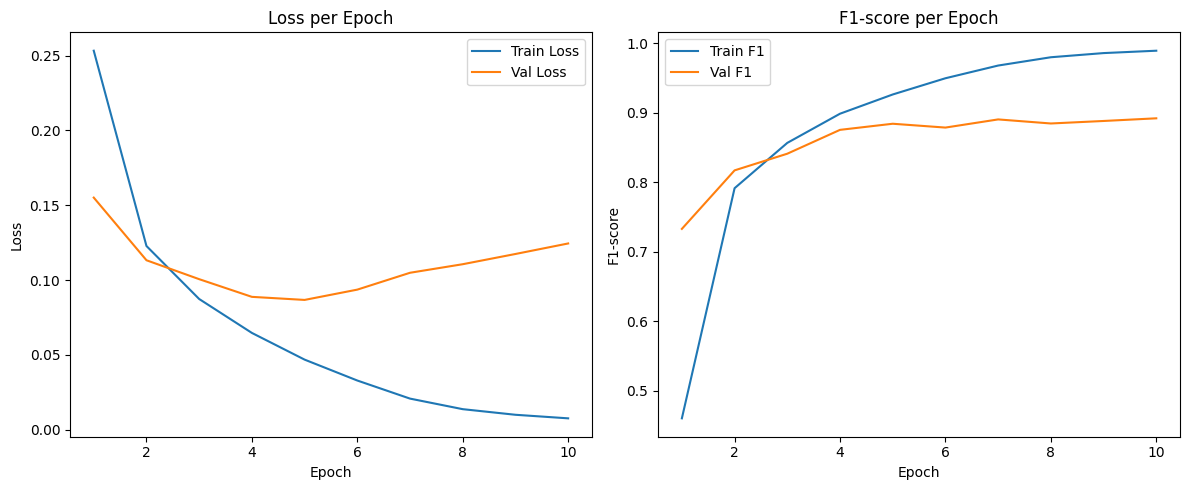

In [38]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# --- F1 ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_f1"], label="Train F1")
plt.plot(epochs, history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score per Epoch")
plt.legend()

plt.tight_layout()

In [36]:
def save_model(model, char2id, out_dir="./checkpoints", model_name="bilstm_space"):
    """
    Сохраняет модель и словарь символов.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Сохраняем веса модели
    torch.save(model.state_dict(), out_dir / f"{model_name}.pt")

    # Сохраняем словарь
    with open(out_dir / f"{model_name}_char2id.json", "w", encoding="utf-8") as f:
        json.dump(char2id, f, ensure_ascii=False, indent=2)

    print(f"Модель и словарь сохранены в {out_dir}")

In [41]:
save_model(model, char2id, out_dir="./model")

Модель и словарь сохранены в model


In [40]:
def load_model(model_class, model_params, checkpoint_dir="./checkpoints", model_name="bilstm_space", device="cpu"):
    """
    Загружает сохранённую модель и словарь символов для инференса или дообучения.
    """
    checkpoint_dir = Path(checkpoint_dir)

    # Загружаем словарь
    with open(checkpoint_dir / f"{model_name}_char2id.json", "r", encoding="utf-8") as f:
        char2id = json.load(f)

    # Создаём модель и загружаем веса
    model = model_class(**model_params)
    state_dict = torch.load(checkpoint_dir / f"{model_name}.pt", map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    print(f"Модель {model_name} успешно загружена с устройства {device}")

    return model, char2id

Модель и словарь сохранены в model
